### Data Profile

In [302]:
# import general libraries
import csv
import pickle
import pandas as pd
import numpy as np
from scipy import stats
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# import data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# import machine learning libraries
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.svm import LinearSVC, SVC
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score,make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier 
from sklearn import svm
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

In [200]:
# read data
df = pd.read_csv('/Users/monkeyjiashuo/Downloads/Project3_bankcampaign/bank/bank-full.csv',
delimiter = ';')

In [201]:
# check the number of features and observations
df.shape

(45211, 17)

In [202]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [203]:
# gives us a general stats info about the numerical data
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [204]:
# there is no missing values from dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


### Analysis of Bank Client

In [205]:
# 1 - age (numeric)
# 2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
# 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
# 4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
# 5 - default: has credit in default? (categorical: 'no','yes','unknown')
# 6 - housing: has housing loan? (categorical: 'no','yes','unknown')
# 7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# 8 - balance: how much balance an individual has

In [206]:
client = df[['age','job','marital','education','default','balance','housing','loan']]

In [207]:
client.head()

,age,job,marital,education,default,balance,housing,loan
0,58,management,married,tertiary,no,2143,yes,no
1,44,technician,single,secondary,no,29,yes,no
2,33,entrepreneur,married,secondary,no,2,yes,yes
3,47,blue-collar,married,unknown,no,1506,yes,no
4,33,unknown,single,unknown,no,1,no,no


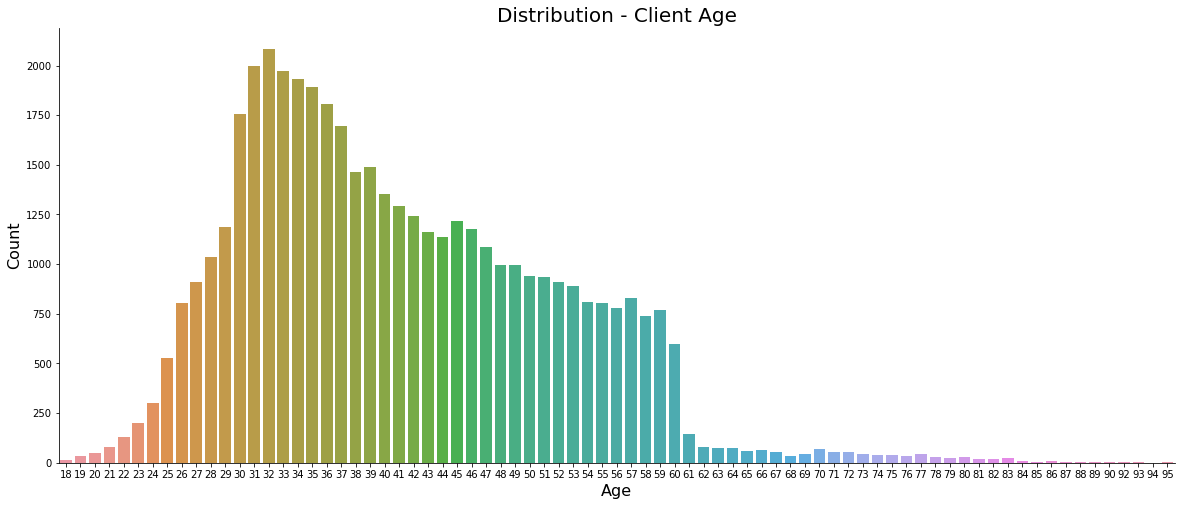

In [208]:
# plot the distribution of clients' age. from the plot we see that the majority of clients
# age between 25 and 60
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(x = 'age', data = client)
ax.set_xlabel('Age', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Distribution - Client Age', fontsize=20)
sns.despine()

In [209]:
# detect outliers for age
quantile_25 = client['age'].quantile(q = .25) # Q1
quantile_50 = client['age'].quantile(q = .5) # Q2
quantile_75 = client['age'].quantile(q = .75) # Q3
IQR = quantile_75 - quantile_25
# lower bound = Q1 - 1.5*IQR
# upper bound = Q3 + 1.5*IQR
lower_bound = quantile_25 - 1.5*IQR
upper_bound = quantile_75 + 1.5*IQR
print('Age below', lower_bound,'or', 'age above', upper_bound, 'are outliers','.')
print('Minimum of age is', client['age'].min(),'.', 'Maximum of age is', client['age'].max(),'.')

Age below 10.5 or age above 70.5 are outliers .
Minimum of age is 18 . Maximum of age is 95 .


In [210]:
# min value for age is 18. so I will just flag age above 71 as outliers
# I'm keeping them so far, will also plot if any clients falling under age outliers bought the term of deposit
# if there are actually a bunch of clients above 71 bought the product, then I should keep them when tranining model
outlier_age = client[client['age'] > 71]
print('Percentage of age outliers is', round(outlier_age['age'].count()/len(client),5))

Percentage of age outliers is 0.00958


In [211]:
## place holder for checking how many clients falling under age outliers bought the terms of deposit

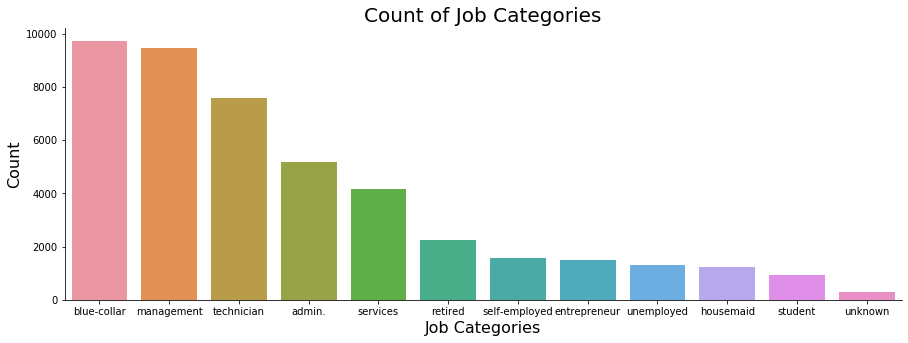

In [212]:
# from the plot we see most of the client we contact are blue-collar, management, technician, admin, services, and retired
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
sns.countplot(x = 'job', data = client,order = client['job'].value_counts().index)
ax.set_xlabel('Job Categories', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Count of Job Categories', fontsize=20)
sns.despine()

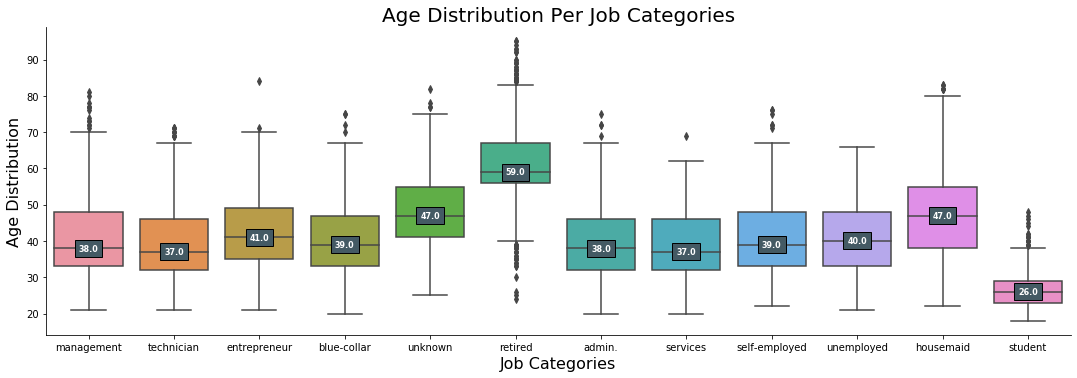

In [213]:
# from the plot we see the age distribution of different job categories. 
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
box_plot = sns.boxplot(x='job', y='age',data = client)
ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    y = round(lines[4+cat*6].get_ydata()[0],1)
    
    ax.text(
    cat,
    y,
    f'{y}', 
    ha='center', 
    va='center', 
    fontweight='bold', 
    size=8,
    color='white',
    bbox=dict(facecolor='#445A64'))

box_plot.figure.tight_layout()

ax.set_xlabel('Job Categories', fontsize=16)
ax.set_ylabel('Age Distribution', fontsize=16)
ax.set_title('Age Distribution Per Job Categories', fontsize=20)
sns.despine()

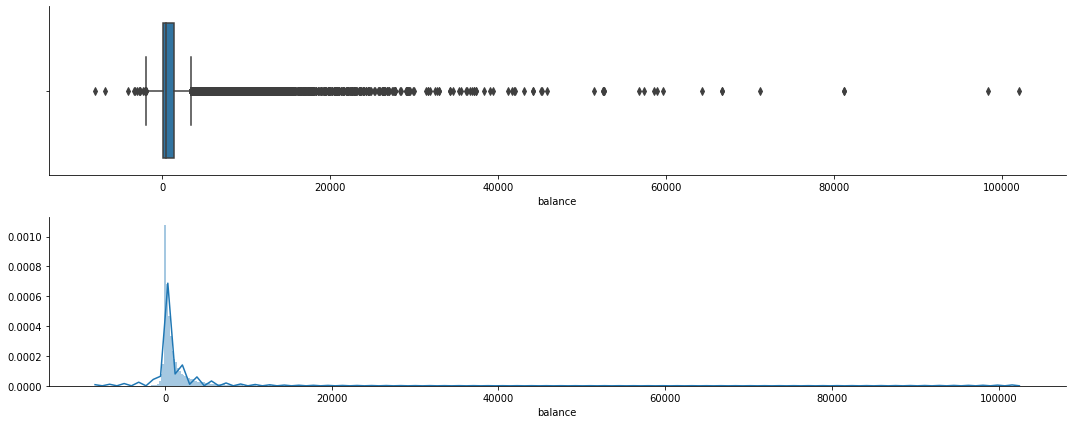

In [214]:
# from the balance distribution plot we see that the majority of clients don't have balance/or have very few balance in their bank account
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 6))
sns.boxplot(client['balance'], ax = ax1)
ax.set_xlabel('Balance', fontsize=16)
ax.set_ylabel('Balance Distribution', fontsize=16)
ax.set_title('Boxplot - Balance', fontsize=20)
sns.despine()

sns.distplot(client['balance'], bins=500, ax = ax2)
ax.set_xlabel('Balance', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
ax.set_title('Distribution - Balance of Clients', fontsize=20)

plt.subplots_adjust(wspace=5)
plt.tight_layout() 

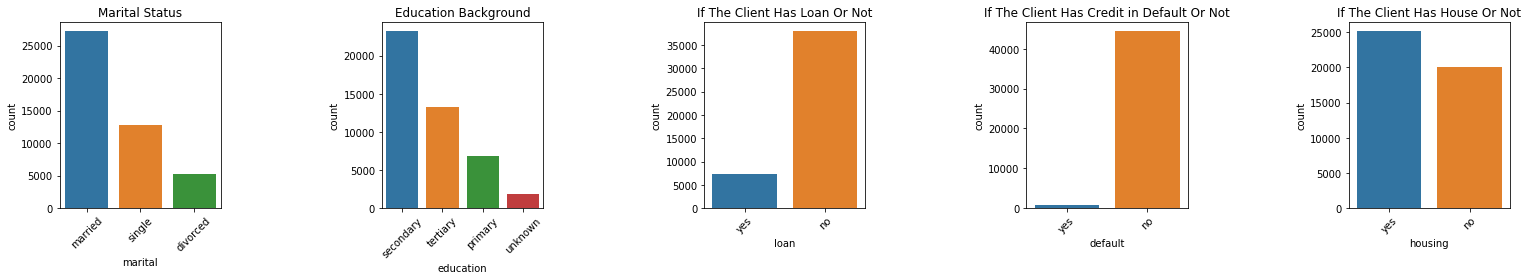

In [215]:
# plot marital and education background of clients
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows = 1, ncols = 5, figsize = (22, 4))
sns.countplot(client['marital'], ax = ax1,order = client['marital'].value_counts().index)
ax1.set_title('Marital Status', fontsize=12)
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

sns.countplot(client['education'], ax = ax2,order = client['education'].value_counts().index)
ax2.set_title('Education Background', fontsize=12)
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)


sns.countplot(client['loan'], ax = ax3,order = ['yes','no'])
ax3.set_title('If The Client Has Loan Or Not', fontsize=12)
for tick in ax3.get_xticklabels():
    tick.set_rotation(45)


sns.countplot(client['default'], ax = ax4,order = ['yes','no'])
ax4.set_title('If The Client Has Credit in Default Or Not', fontsize=12)
for tick in ax4.get_xticklabels():
    tick.set_rotation(45)


sns.countplot(client['housing'], ax = ax5,order = ['yes','no'])
ax5.set_title('If The Client Has House Or Not', fontsize=12)
for tick in ax5.get_xticklabels():
    tick.set_rotation(45)

plt.subplots_adjust(wspace=3.5)
plt.tight_layout() 

### Analysis of The Last Contact of Current Campaign

In [216]:
# # related with the last contact of the current campaign:
# 9 - contact: contact communication type (categorical: 'cellular','telephone') 
# 10 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
# 11 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
# 12 - duration: last contact duration, in seconds (numeric). 

In [217]:
last_contact_current = df[['contact','month','day','duration']]

In [218]:
# somehow the dataset I used doesn't align with the data profile from source site
# they seperate bank_additional and bank_full datasets. the one I'm using doesn't include day_of_week feature;
# instead, I have the day of month feature... I'm thinking of dropping it to train model
last_contact_current.head()

,contact,month,day,duration
0,unknown,may,5,261
1,unknown,may,5,151
2,unknown,may,5,76
3,unknown,may,5,92
4,unknown,may,5,198


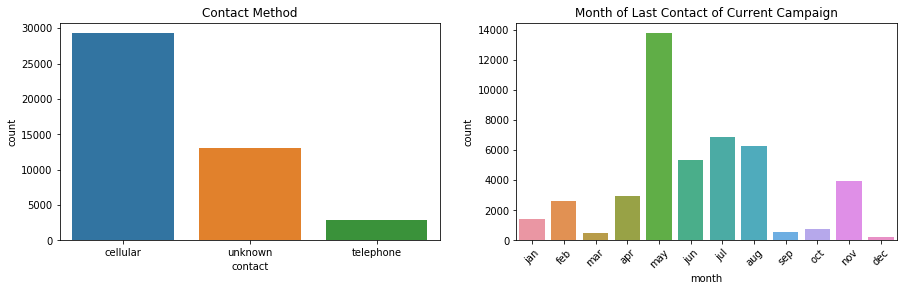

In [219]:
# plot contact and month features for the last contact of current campaign
# from the contact method plot I found that most of the contacts are via cellphone
# from the month plot I found that most frequent campaign activities happen from May to August, summer time
# not much activity happen in winter (except for November)
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 4))
sns.countplot(last_contact_current['contact'], ax = ax1,order = last_contact_current['contact'].value_counts().index)
ax1.set_title('Contact Method', fontsize=12)

sns.countplot(last_contact_current['month'], ax = ax2,order = ['jan', 'feb','mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec'])
ax2.set_title('Month of Last Contact of Current Campaign', fontsize=12)
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)

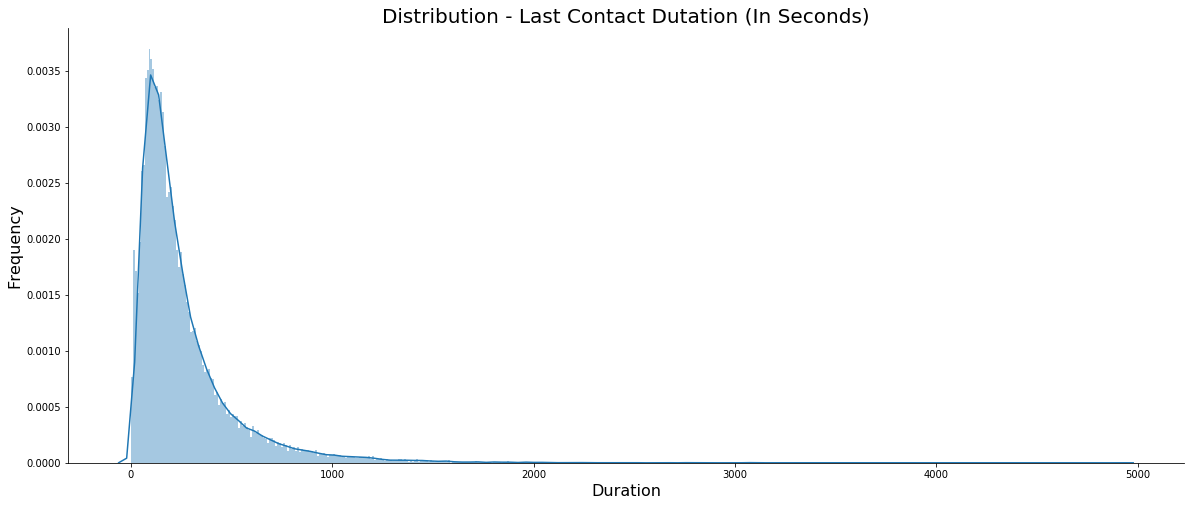

In [220]:
# the duration feature will be dropped when training the model
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.distplot(last_contact_current['duration'], bins=500)
ax.set_xlabel('Duration', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
ax.set_title('Distribution - Last Contact Dutation (In Seconds)', fontsize=20)
sns.despine()

### Analysis of Other Attributes of Campaign

In [221]:
# 13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
# 14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
# 15 - previous: number of contacts performed before this campaign and for this client (numeric)
# 16 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')÷

In [222]:
campaign_other = df[['campaign','pdays','previous','poutcome']]

In [223]:
campaign_other.head()

,campaign,pdays,previous,poutcome
0,1,-1,0,unknown
1,1,-1,0,unknown
2,1,-1,0,unknown
3,1,-1,0,unknown
4,1,-1,0,unknown


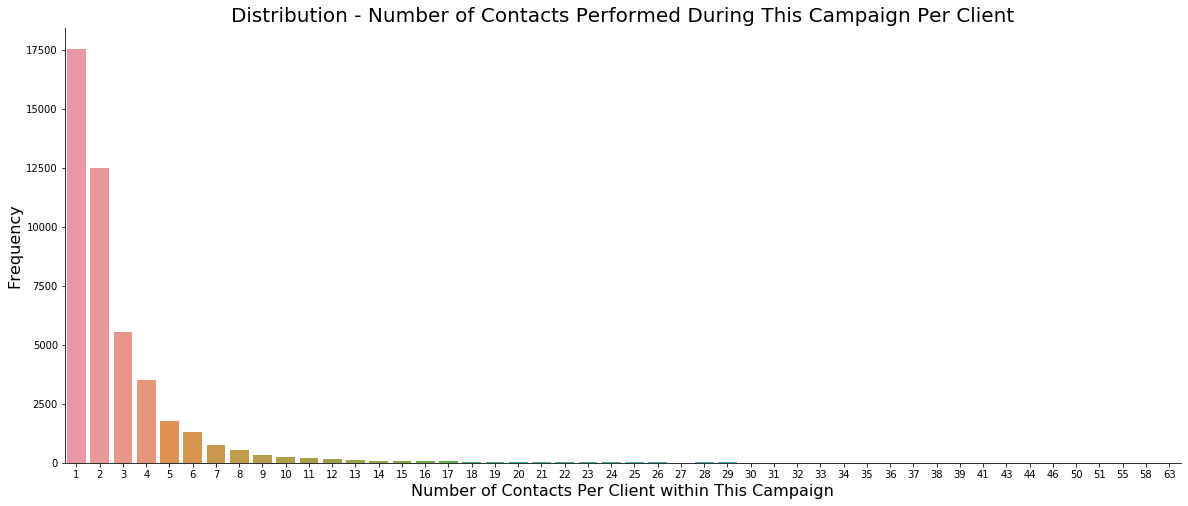

In [224]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(campaign_other['campaign'])
ax.set_xlabel('Number of Contacts Per Client within This Campaign', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
ax.set_title('Distribution - Number of Contacts Performed During This Campaign Per Client', fontsize=20)
sns.despine()

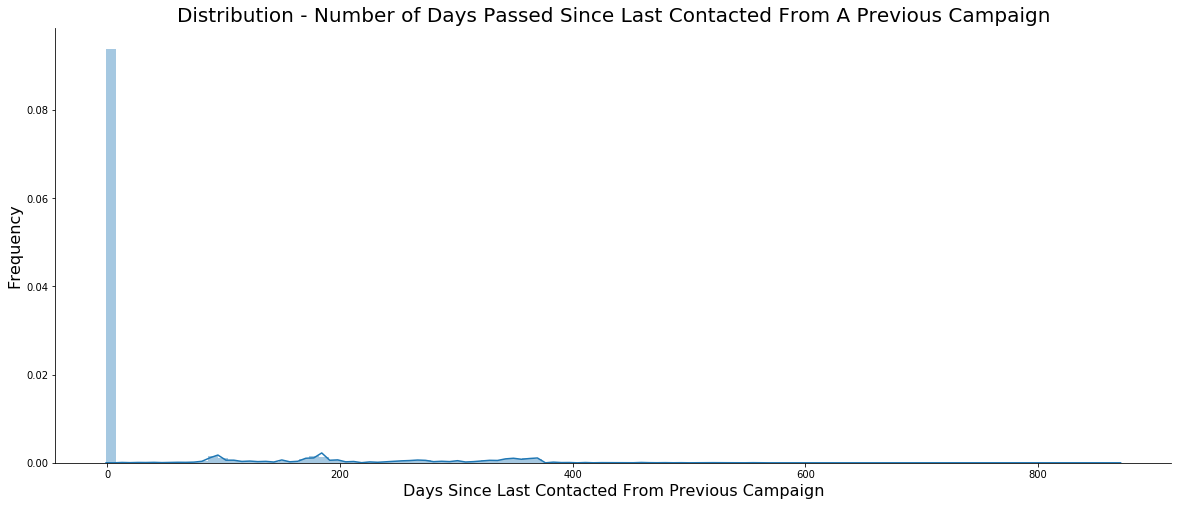

In [225]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.distplot(campaign_other['pdays'], bins = 100)
ax.set_xlabel('Days Since Last Contacted From Previous Campaign', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
ax.set_title('Distribution - Number of Days Passed Since Last Contacted From A Previous Campaign', fontsize=20)
sns.despine()

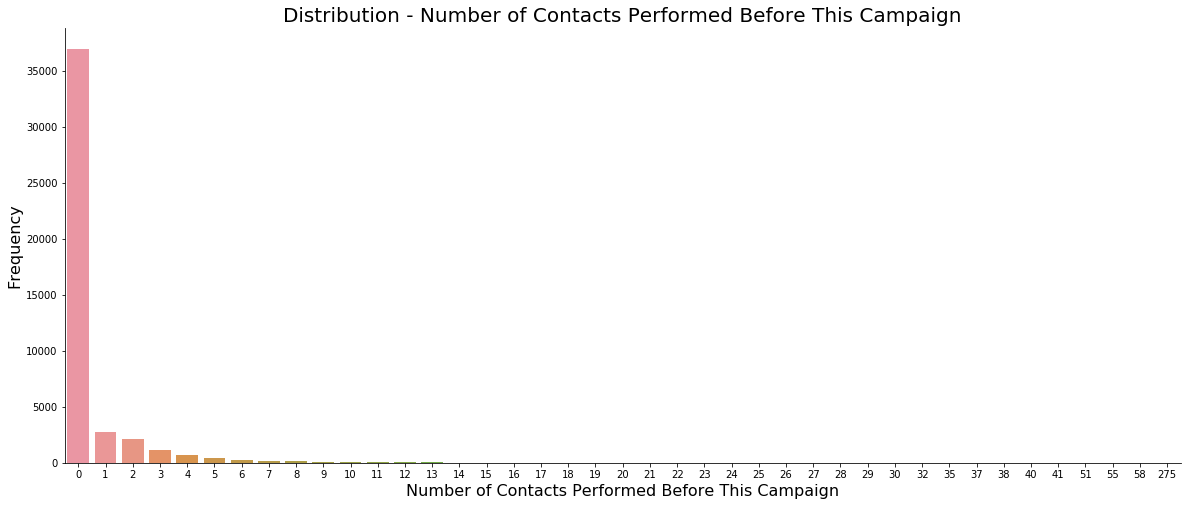

In [226]:
# from the plot we could see that most of clients haven't been contacted before this campaign
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(campaign_other['previous'])
ax.set_xlabel('Number of Contacts Performed Before This Campaign', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
ax.set_title('Distribution - Number of Contacts Performed Before This Campaign', fontsize=20)
sns.despine()

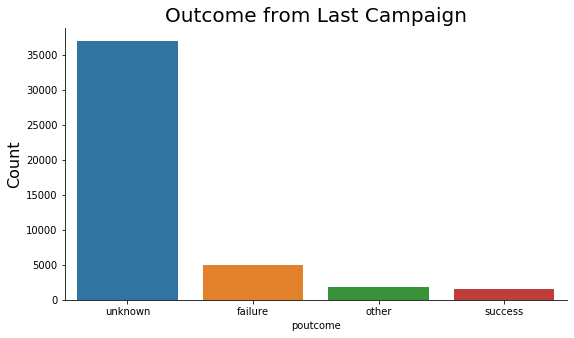

In [227]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 5)
sns.countplot(x = 'poutcome', data = campaign_other)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Outcome from Last Campaign', fontsize=20)
sns.despine()

In [228]:
## need to drop the column 'duration' as stated from the data description. 
## duration is highly affects the target y. duration is not yet known before making the call.
## however, the target output is already know after the call, so need to drop this feature
## day was just the date, I don't think it would relate to the analysis. so I'll drop it
## poutcome has lots of 'unknown' value. I also drop this feature
df = df.drop(['duration','day','poutcome'],axis = 1)
df.shape

(45211, 14)

In [229]:
# transform target values into dummies
target_y_n ={'yes' : 1, 'no' : 0}
df['y'] = df['y'].map(lambda x: target_y_n[x])
df['y'].value_counts()

0    39922
1     5289
Name: y, dtype: int64

In [230]:
# split the 'y' column as it's the outcome
X, y = df.drop('y', axis = 1), df['y']

In [231]:
print(X.shape)
print(y.shape)

(45211, 13)
(45211,)


In [232]:
# transform categorical data to dummies
X = pd.get_dummies(X, drop_first=True)

In [233]:
# hold out 20% of the data as test data for final model run
X, X_test, y, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [234]:
# for later training random forest model 
# otherwise numpy.array object won't work for feature importance
X_copy = X.copy()

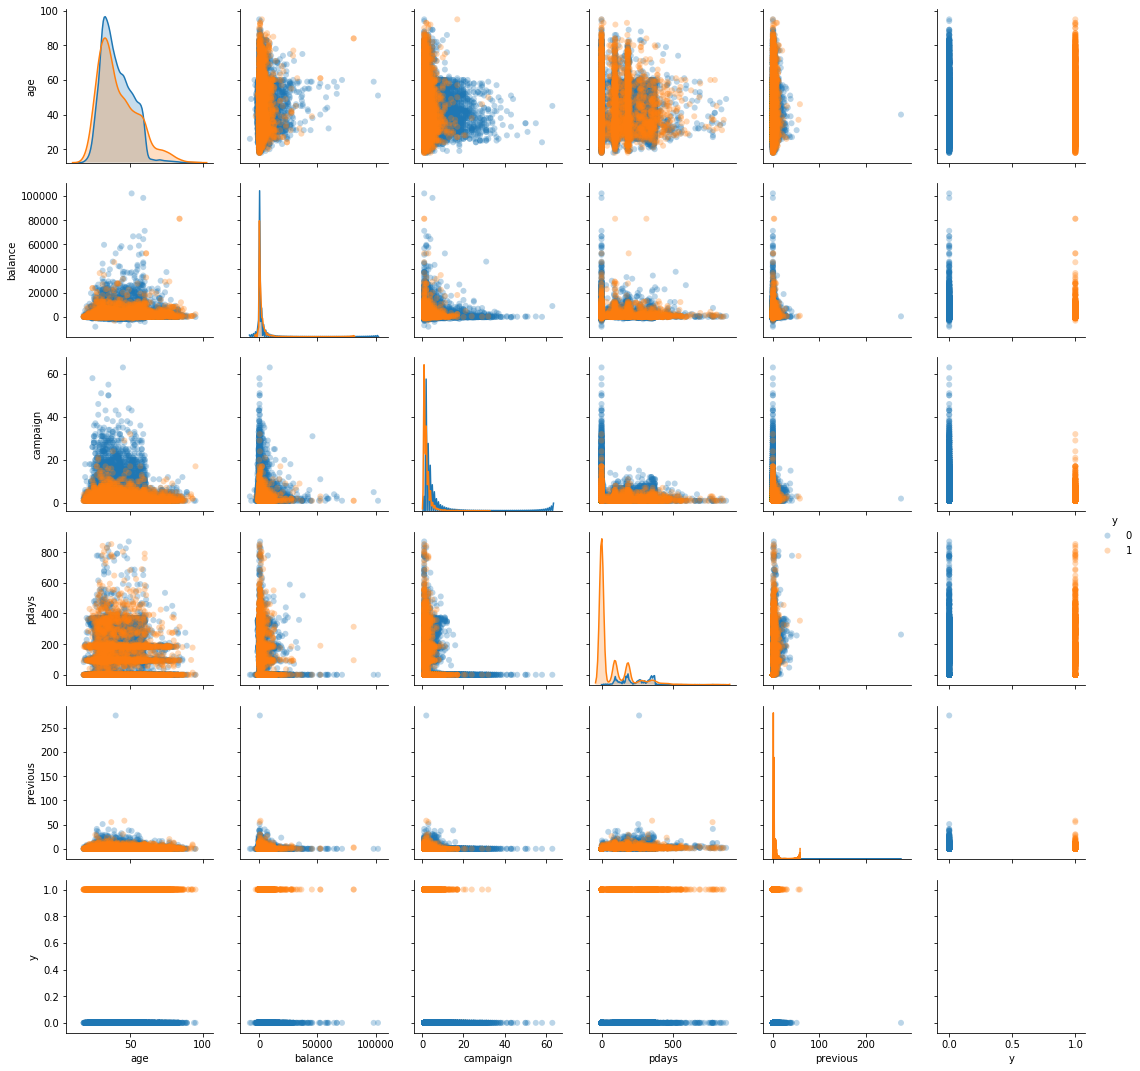

In [235]:
# aiming at seeing the diagonals and include which features in training models (usually the ones which seperate class well)
# at this point I will just fit all features first
sns.pairplot(df,hue='y', plot_kws=dict(alpha=.3, edgecolor='none'))

In [236]:
# scale features with minmax scaler
mn = MinMaxScaler()
X = mn.fit_transform(X.values)
X_test = mn.transform(X_test)

### Imbalance - Over Sampling
I have have the over sampling part after choosing the best model to avoid extremely computational expensive

In [237]:
# from the output below we could easily diagnose that the target output we are going to predict is very imbalanced
# so we need to apply some over sampling techniques (random over sampling or SMOTE)
# I don't want to lose my data, so I try to avoid under sampling
target_count = df.y.value_counts()
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')
print(f'Percentage of Minority Class: {round(target_count[1] / sum(target_count), 4)*100}')

Class 0: 39922
Class 1: 5289
Proportion: 7.55 : 1
Percentage of Majority Class: 88.3
Percentage of Minority Class: 11.700000000000001


In [238]:
# add some smote oversampling of the minority classes
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X,y)

In [239]:
# oversampling X_copy (X_copy is the copy of X before scaling)
X_copy_smoted, y_copy_smoted = SMOTE(random_state=42).fit_sample(X_copy,y)

In [240]:
Counter(y_smoted)

Counter({0: 31932, 1: 31932})

In [241]:
Counter(y_copy_smoted)

Counter({0: 31932, 1: 31932})

### Modeling

#### Set up k_folds = 5

In [243]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=10) 

#### ChooseMetric
In my case, I care both precision and recall(but lean more towards recall). Since my target output is imbalanced (only about 1/10 clients would buy the term of deposit), so I will use F-beta as my performance metric

In [244]:
ftwo_scorer = make_scorer(fbeta_score, beta=2)
# y = y.astype(np.uint8)

#### <font color='red'>Logistic Regression with Grid Search</font>

In [245]:
# train logistic regression model
param_grid = {'C': [i for i in range(5, 20)] }
clf_logistic = GridSearchCV(LogisticRegression(), param_grid, cv=k_fold, scoring=ftwo_scorer, n_jobs=-1)
clf_logistic.fit(X_smoted, y_smoted)

GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                               18, 19]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(fbeta_score, beta=2), verbose=0)

In [246]:
print(clf_logistic.best_score_)
print(clf_logistic.best_params_)
print(clf_logistic.best_estimator_)

0.6953718103424205
{'C': 12}
LogisticRegression(C=12, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [247]:
# import pprint as pp
# pp.pprint(clf_logistic.cv_results_)

In [248]:
# best logistic regression model
logistic_model = clf_logistic.best_estimator_

In [249]:
# can make some interesting arguements about logistic regression coefficients
# previous has the strongest contribution to predicting 'yes' with logistic regression model. 
# previous is the number of contacts performed before this campaign and for this client (numeric), which means it's important to keep relationship/touch with clients
# however, campaign (number of contacts performed during this campaign and for this client) has the strongest negtive effect on predicting 'yes'
# so it means that even tho it's important to contact the clients, but the marketing team don't want to bug clients in an annoying way
# espetially within a period/within a campaign
# balance contributes positively, which makes sense - clients with extra money are more likely to invest
# clients with higher education (tertiary and secondary) are more likely to by term of deposits
# months are interesting - march, october, december, and september contribute better
# occupation: retired and students tend to buy term of deposit
# logistic regression is interpretable and awesome!
log_coef = pd.DataFrame(logistic_model.coef_, columns=X_copy.columns)
log_coef = log_coef.melt()

log_coef = log_coef.sort_values(by=['value'], ascending = False)
log_coef

,variable,value
4,previous,21.541272
1,balance,2.007201
32,month_mar,1.018480
35,month_oct,0.908311
27,month_dec,0.703443
36,month_sep,0.701711
19,education_tertiary,0.407600
9,job_retired,0.304778
12,job_student,0.177122
20,education_unknown,0.173771


Text(0.5, 1, 'Logistic Regression Confusion Matrix')

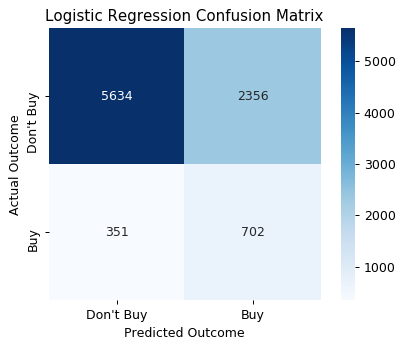

In [250]:
# confusion matrix for logistic regression
logistic_confusion = confusion_matrix(y_test, logistic_model.predict(X_test))
plt.figure(dpi=90)
sns.heatmap(logistic_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt='g',
           xticklabels= ['Don\'t Buy','Buy'],
           yticklabels= ['Don\'t Buy','Buy'])

plt.xlabel('Predicted Outcome')
plt.ylabel('Actual Outcome')
plt.title('Logistic Regression Confusion Matrix')

ROC AUC score =  0.7493449195159666


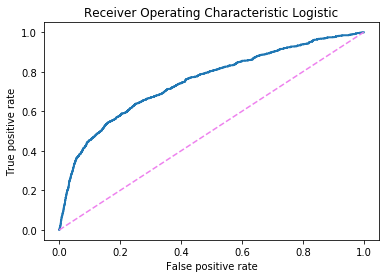

In [251]:
# ROC curve logistic regression
fpr_log, tpr_log, thresholds_log = roc_curve(y_test, logistic_model.predict_proba(X_test)[:,1])
plt.plot(fpr_log, tpr_log,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Characteristic Logistic');
print("ROC AUC score = ", roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:,1]))

#### <font color='red'>SVM with Grid Search</font>

In [ ]:
# # Rebuild the SVM classifier as LinearSVC() doesn't have attribute to plot ROC curve
# # but this code took forever to get the result, so I gave up on svm
# classifier = svm.SVC(kernel='linear', probability=True,
#                      random_state=1)

# param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
# clf_svm2 = RandomizedSearchCV(classifier, param_grid, cv=k_fold, scoring=ftwo_scorer, n_jobs=-1)
# clf_svm2.fit(X_smoted,y_smoted)

In [316]:
# original code for SVM classifier
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf_svm = RandomizedSearchCV(LinearSVC(), param_grid, cv=k_fold, scoring=ftwo_scorer, n_jobs=-1)
clf_svm.fit(X_smoted,y_smoted)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                       fit_intercept=True, intercept_scaling=1,
                                       loss='squared_hinge', max_iter=1000,
                                       multi_class='ovr', penalty='l2',
                                       random_state=None, tol=0.0001,
                                       verbose=0),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100,
                                              1000]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring=make_scorer(fbeta_score, beta=2), verbose=0)

In [ ]:
# this code is benefit for plotting ROC curve
# since 'LinearSVC' object has no attribute 'predict_proba'
# but somehow it's running too slow
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf_svm = RandomizedSearchCV(SVC(kernel='linear',probability=True), param_grid, cv=k_fold, scoring=ftwo_scorer, n_jobs=-1)
clf_svm.fit(X_smoted,y_smoted)

In [317]:
SklearnClassifier(SVC(kernel='linear',probability=True))

<SklearnClassifier(SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False))>

In [318]:
print(clf_svm.best_score_)
print(clf_svm.best_params_)
print(clf_svm.best_estimator_)

0.7057395436491406
{'C': 1000}
LinearSVC(C=1000, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


In [319]:
# best svm model
svm_model = clf_svm.best_estimator_

Text(0.5, 1, 'SVM Confusion Matrix')

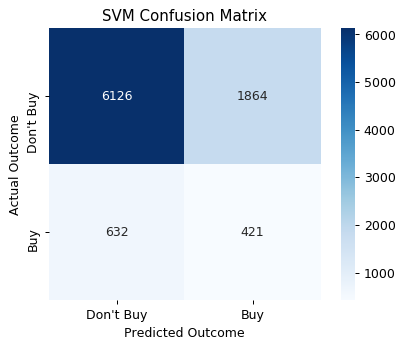

In [320]:
# confusion matrix for SVM classification
svm_confusion = confusion_matrix(y_test, svm_model.predict(X_test))
plt.figure(dpi=90)
sns.heatmap(svm_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt='g',
            xticklabels= ['Don\'t Buy','Buy'],
            yticklabels= ['Don\'t Buy','Buy'])

plt.xlabel('Predicted Outcome')
plt.ylabel('Actual Outcome')
plt.title('SVM Confusion Matrix')

In [321]:
# ROC curve SVM classification
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, svm_model.predict_proba(X_test)[:,1])
plt.plot(fpr_svm, tpr_svm,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Characteristic SVM');
print("ROC AUC score = ", roc_auc_score(y_test, svm_model.predict_proba(X_test)[:,1]))

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

#### <font color='red'>KNN with Grid Search</font>
Took forver to run the results. save it to the last to execute.
If running out of time then I'll skip KNN.

In [ ]:
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
clf_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=k_fold, scoring=ftwo_scorer, n_jobs=-1)
clf_knn.fit(X_smoted, y_smoted)

In [737]:
knn_model = clf_knn.best_estimator_

Text(0.5, 1, 'KNN Confusion Matrix')

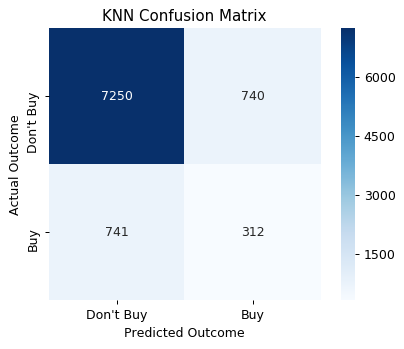

In [752]:
# confusion matrix for KNN classification
knn_confusion = confusion_matrix(y_test, knn_model.predict(X_test))
plt.figure(dpi=90)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt='g',
           xticklabels= ['Don\'t Buy','Buy'],
           yticklabels= ['Don\'t Buy','Buy'])

plt.xlabel('Predicted Outcome')
plt.ylabel('Actual Outcome')
plt.title('KNN Confusion Matrix')

In [322]:
# ROC curve KNN classification
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, knn_model.predict_proba(X_test)[:,1])
plt.plot(fpr_knn, tpr_knn,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Characteristic KNN');
print("ROC AUC score = ", roc_auc_score(y_test, knn_model.predict_proba(X_test)[:,1]))

NameError: name 'knn_model' is not defined

In [739]:
# Dump the trained KNN classifier with Pickle
knn_basic_file = 'knn_basic.pkl'
# Open the file to save as pkl file
knn_basic_pkl = open(knn_basic_file, 'wb')
pickle.dump(clf_knn, knn_basic_pkl)
# Close the pickle instances
knn_basic_pkl.close()

In [740]:
# unpickle
# Need to open the pickled list object into read mode
knn_basic_file = 'knn_basic.pkl'
knn_basic_unpickle = open(knn_basic_file, 'rb')
 
# load the unpickle object into a variable
knn_basic = pickle.load(knn_basic_unpickle)

#### <font color='red'>Decision Tree with Grid Search</font>

In [262]:
# hyper parameter tuning - using grid search to find the best decision tree depth
param_grid = {'max_depth':range(3,30)}
clf_tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=k_fold, scoring=ftwo_scorer, n_jobs=-1)
clf_tree.fit(X=X_smoted, y=y_smoted)

GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1, param_grid={'max_depth': range(3, 30)},
             pre_dispatch='2*n_jobs', 

In [263]:
print(clf_tree.best_score_)
print(clf_tree.best_params_)
print(clf_tree.best_estimator_)

0.8758323345747956
{'max_depth': 27}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=27,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


In [264]:
tree_model = clf_tree.best_estimator_

Text(0.5, 1, 'Decision Tree Confusion Matrix')

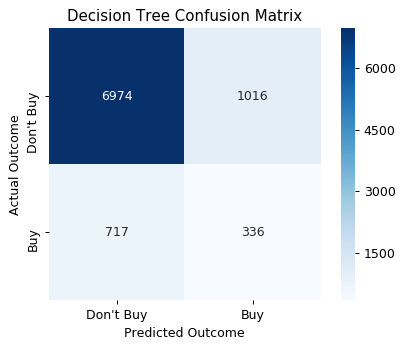

In [265]:
# confusion matrix for decision tree 
tree_confusion = confusion_matrix(y_test, tree_model.predict(X_test))
plt.figure(dpi=90)
sns.heatmap(tree_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt='g',
           xticklabels= ['Don\'t Buy','Buy'],
           yticklabels= ['Don\'t Buy','Buy'])
    
plt.xlabel('Predicted Outcome')
plt.ylabel('Actual Outcome')
plt.title('Decision Tree Confusion Matrix')

ROC AUC score =  0.5966236285385221


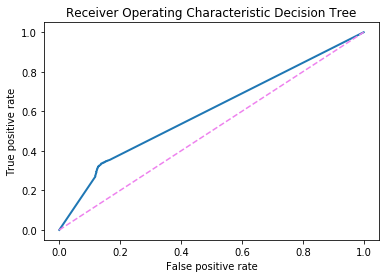

In [266]:
# ROC curve decision tree classification
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, tree_model.predict_proba(X_test)[:,1])
plt.plot(fpr_tree, tpr_tree,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Characteristic Decision Tree');
print("ROC AUC score = ", roc_auc_score(y_test, tree_model.predict_proba(X_test)[:,1]))

#### <font color='red'>Random Forest with Grid Search</font>

In [267]:
# hyper parameter tuning - using grid search to find the best random forest depth
param_grid = {'max_depth':range(3,30)}
clf_random = RandomizedSearchCV(RandomForestClassifier(), param_grid, cv=k_fold, scoring=ftwo_scorer, n_jobs=-1)
clf_random.fit(X=X_copy_smoted, y=y_copy_smoted)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn

In [274]:
print(clf_random.best_score_)
print(clf_random.best_params_)
print(clf_random.best_estimator_)

0.9042403136320437
{'max_depth': 25}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [275]:
random_model = clf_random.best_estimator_

Text(0.5, 1, 'Random Forest Confusion Matrix')

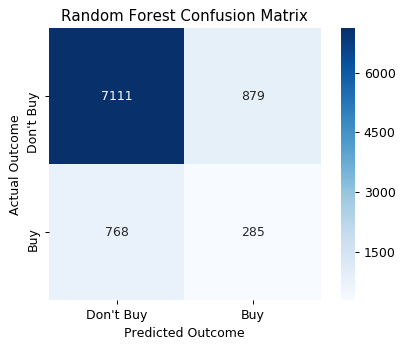

In [276]:
# confusion matrix for random forest
random_confusion = confusion_matrix(y_test, random_model.predict(X_test))
plt.figure(dpi=90)
sns.heatmap(random_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt='g',
           xticklabels= ['Don\'t Buy','Buy'],
           yticklabels= ['Don\'t Buy','Buy'])
    
plt.xlabel('Predicted Outcome')
plt.ylabel('Actual Outcome')
plt.title('Random Forest Confusion Matrix')

ROC AUC score =  0.6320982900040054


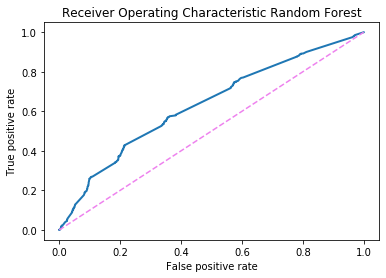

In [277]:
# ROC curve Random Forest classification
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, random_model.predict_proba(X_test)[:,1])
plt.plot(fpr_rf, tpr_rf,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Characteristic Random Forest');
print("ROC AUC score = ", roc_auc_score(y_test, random_model.predict_proba(X_test)[:,1]))

In [278]:
# feat_importances = pd.Series(random_model.feature_importances_, index=X_copy.columns)

In [282]:
# Analyze features importance
feature_importances = pd.DataFrame(random_model.feature_importances_,
                                   index = X_copy.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [283]:
# contact_unknow gives the most importance, which is weird
feature_importances.sort_values(by=['importance'], ascending = False)

,importance
balance,0.099205
housing_yes,0.086694
age,0.076866
month_may,0.067409
contact_unknown,0.063900
month_aug,0.052478
month_jul,0.045546
marital_married,0.043555
campaign,0.043013
pdays,0.041545


#### <font color='red'>XG Boost with Grid Search</font>

In [284]:
# hyper parameter tuning - using grid search to find the best XGBoost depth
param_grid = {'max_depth':range(3,30)}
clf_XGB = RandomizedSearchCV(XGBClassifier(), param_grid, cv=k_fold, scoring=ftwo_scorer, n_jobs=-1)
clf_XGB.fit(X=X_smoted, y=y_smoted)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scale_pos_weight=1,
                                           seed=None, silent=None, subsample=1,
 

In [285]:
print(clf_XGB.best_score_)
print(clf_XGB.best_params_)
print(clf_XGB.best_estimator_)

0.9081979483057909
{'max_depth': 24}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=24,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [286]:
XGB_model = clf_XGB.best_estimator_

Text(0.5, 1, 'XGBoost Confusion Matrix')

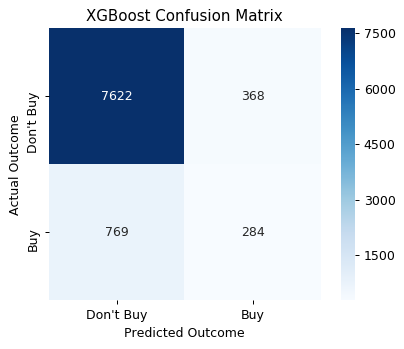

In [287]:
# confusion matrix for XGBoost
# the code takes forver to run. I will submit the code first then update the new results
XGB_confusion = confusion_matrix(y_test, XGB_model.predict(X_test))
plt.figure(dpi=90)
sns.heatmap(XGB_confusion, cmap=plt.cm.Blues, annot=True, square=True,fmt='g',
           xticklabels= ['Don\'t Buy','Buy'],
           yticklabels= ['Don\'t Buy','Buy'])
    
plt.xlabel('Predicted Outcome')
plt.ylabel('Actual Outcome')
plt.title('XGBoost Confusion Matrix')

ROC AUC score =  0.7387365736135031


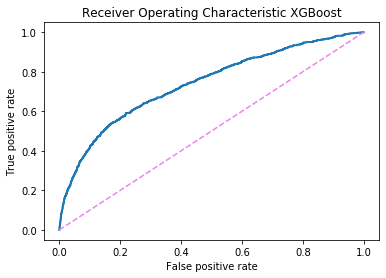

In [288]:
# ROC curve XGBoost classification
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, XGB_model.predict_proba(X_test)[:,1])
plt.plot(fpr_xgb, tpr_xgb,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver Operating Characteristic XGBoost');
print("ROC AUC score = ", roc_auc_score(y_test, XGB_model.predict_proba(X_test)[:,1]))

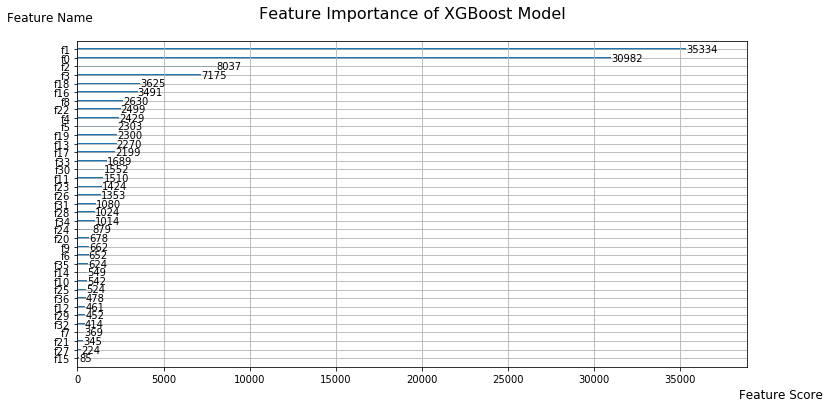

In [306]:
# plot feature importance of XGBoost model
# since I scale the dataframe so it's np array type...
# feature names are gone... would like to fix it if I have more time...
fig, ax = plt.subplots(figsize=(12, 6))
plot_importance(XGB_model, ax =ax)
plt.title('Feature Importance of XGBoost Model', fontsize = '16', y= 1.05)
plt.xlabel(xlabel = 'Feature Score', x = 1.05, fontsize = '12')
plt.ylabel(ylabel = 'Feature Name', rotation = 0, y = 1.05, fontsize = '12')
plt.show()

In [327]:
print(*enumerate(X_copy.columns), sep='\n')

(0, 'age')
(1, 'balance')
(2, 'campaign')
(3, 'pdays')
(4, 'previous')
(5, 'job_blue-collar')
(6, 'job_entrepreneur')
(7, 'job_housemaid')
(8, 'job_management')
(9, 'job_retired')
(10, 'job_self-employed')
(11, 'job_services')
(12, 'job_student')
(13, 'job_technician')
(14, 'job_unemployed')
(15, 'job_unknown')
(16, 'marital_married')
(17, 'marital_single')
(18, 'education_secondary')
(19, 'education_tertiary')
(20, 'education_unknown')
(21, 'default_yes')
(22, 'housing_yes')
(23, 'loan_yes')
(24, 'contact_telephone')
(25, 'contact_unknown')
(26, 'month_aug')
(27, 'month_dec')
(28, 'month_feb')
(29, 'month_jan')
(30, 'month_jul')
(31, 'month_jun')
(32, 'month_mar')
(33, 'month_may')
(34, 'month_nov')
(35, 'month_oct')
(36, 'month_sep')


#### Plot All ROC Curves

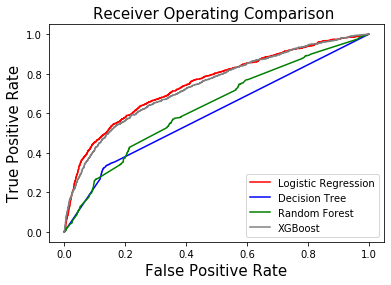

In [314]:
# plot all roc curves in the same graph
# XGBoost seems to perform the best
plt.plot(fpr_log, tpr_log, 'b', label = 'Logistic Regression', color='red')
plt.plot(fpr_tree, tpr_tree, 'b', label = 'Decision Tree', color='blue')
plt.plot(fpr_rf, tpr_rf, 'b', label = 'Random Forest', color='green')
plt.plot(fpr_xgb, tpr_xgb, 'b', label = 'XGBoost', color='grey')
plt.title('Receiver Operating Comparison ',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.xlabel('False Positive Rate',fontsize=15)
plt.legend(loc = 'lower right', prop={'size': 10})

# plt.subplots_adjust(wspace=0.2)
# plt.tight_layout() 